In [1]:
import pandas as pd
import numpy as np
import arviz as az

In [2]:
df_vietnam = pd.read_excel(r'alldatasets.xlsx',sheet_name='Vietnam')

In [3]:
df_vietnam.head()

,childid,country,height,stunting_2cat,EDUYRS2,z_score,timeschool,agegapr1,momeduyrsr1,chsexr1,agemonr1,hhsizer1,wi_newr1,job_cat,pvt_sector,earn,earn_usd
0,VN011001,Vietnam,170.000000,1,12.0,-0.493371,5.0,NaN,12.0,1,91,5,0.561111,1,1,0.0,0.000000
1,VN011002,Vietnam,153.500000,1,12.0,-0.795860,15.0,3.0,9.0,0,92,6,0.546296,1,1,0.0,0.000000
2,VN011003,Vietnam,158.000000,1,8.0,-1.421140,5.0,7.0,6.0,0,100,5,0.455556,2,1,19200000.0,875.313416
3,VN011004,Vietnam,157.500000,0,12.0,-0.539453,10.0,0.0,9.0,0,94,6,0.592593,5,1,4600000.0,209.710495
4,VN011005,Vietnam,157.600006,0,16.0,-0.297198,10.0,4.0,0.0,0,95,5,0.466667,5,1,2800000.0,127.649872


In [4]:
df_vietnam.columns

Index(['childid', 'country', 'height', 'stunting_2cat', 'EDUYRS2', 'z_score',
       'timeschool', 'agegapr1', 'momeduyrsr1', 'chsexr1', 'agemonr1',
       'hhsizer1', 'wi_newr1', 'job_cat', 'pvt_sector', 'earn', 'earn_usd'],
      dtype='object')

In [5]:
from scipy import stats
import scipy.stats as stats

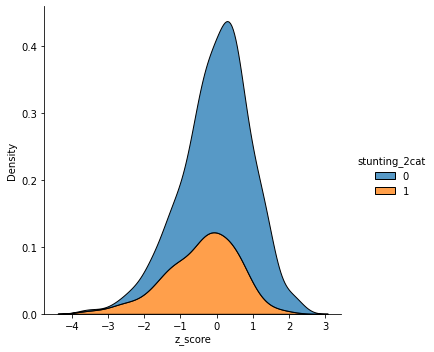

In [6]:
import seaborn as sns
sns.displot(df_vietnam, x="z_score", hue="stunting_2cat", kind="kde", multiple="stack")

In [7]:
df_vietnam=df_vietnam.astype({"chsexr1": 'object', "job_cat": 'object', "pvt_sector": 'object',"stunting_2cat": 'object'})

In [8]:
df_outlier=df_vietnam.copy()

In [9]:
total = df_outlier.isnull().sum().sort_values(ascending=False)
percent = (df_outlier.isnull().sum()/df_outlier.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Missing Percent'])
missing_data['Missing Percent'] = missing_data['Missing Percent'].apply(lambda x: x * 100)
missing_data.loc[missing_data['Missing Percent'] > 95]

,Total,Missing Percent


In [10]:
df_outlier=df_outlier.select_dtypes(include=['int64','floating'])

In [11]:
df_outlier.dtypes

height         float64
EDUYRS2        float64
z_score        float64
timeschool     float64
agegapr1       float64
momeduyrsr1    float64
agemonr1         int64
hhsizer1         int64
wi_newr1       float64
earn           float64
earn_usd       float64
dtype: object

In [12]:
import warnings

warnings.filterwarnings('ignore')

In [13]:
df_outlier.dtypes

height         float64
EDUYRS2        float64
z_score        float64
timeschool     float64
agegapr1       float64
momeduyrsr1    float64
agemonr1         int64
hhsizer1         int64
wi_newr1       float64
earn           float64
earn_usd       float64
dtype: object

In [14]:
def cap_data(df):
    for col in df.columns:
        print("capping the ",col)
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64') | ((df[col].dtype)=='float32')):
            percentiles = df[col].quantile([0.01,0.99]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df



In [15]:
final_df=cap_data(df_outlier)

capping the  height
capping the  EDUYRS2
capping the  z_score
capping the  timeschool
capping the  agegapr1
capping the  momeduyrsr1
capping the  agemonr1
capping the  hhsizer1
capping the  wi_newr1
capping the  earn
capping the  earn_usd


In [16]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

In [17]:
df_vietnam=df_vietnam.drop(['childid','country'],axis=1)

In [18]:
all_category_features=df_vietnam.select_dtypes(include='object')

In [19]:
all_category_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   stunting_2cat  801 non-null    object
 1   chsexr1        801 non-null    object
 2   job_cat        801 non-null    object
 3   pvt_sector     801 non-null    object
dtypes: object(4)
memory usage: 25.2+ KB


# KNN for Categories

In [20]:
mm = MinMaxScaler()

def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].dropna().unique(), 0)}

def integer_encode(df , variable, ordinal_mapping):
    df[variable] = df[variable].map(ordinal_mapping)

mappin = dict()
def imputation(df1 , cols):
    df = df1.copy()
    #Encoding dict &amp; Removing nan    
    #mappin = dict()
    for variable in cols:
        mappings = find_category_mappings(df, variable)
        mappin[variable] = mappings

    #Apply mapping
    for variable in cols:
        integer_encode(df, variable, mappin[variable])  

    #Minmaxscaler and KNN imputation 
    sca = mm.fit_transform(df)
    knn_imputer = KNNImputer()
    knn = knn_imputer.fit_transform(sca)
    df.iloc[:,:] = mm.inverse_transform(knn)
    for i in df.columns : 
        df[i] = round(df[i]).astype('int')

    #Inverse transform
    for i in cols:
        inv_map = {v: k for k, v in mappin[i].items()}
        df[i] = df[i].map(inv_map)
    return df

In [21]:
df_cat_imp=imputation(all_category_features,['stunting_2cat','chsexr1','job_cat','pvt_sector'])

In [22]:
df_cat_imp.isnull().sum().sort_values(ascending = False)

pvt_sector       0
job_cat          0
chsexr1          0
stunting_2cat    0
dtype: int64

In [23]:
df_cat_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   stunting_2cat  801 non-null    int64
 1   chsexr1        801 non-null    int64
 2   job_cat        801 non-null    int64
 3   pvt_sector     801 non-null    int64
dtypes: int64(4)
memory usage: 25.2 KB


# KNN for numerics

In [24]:
df_knn=final_df.copy()

In [25]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_num_imp = pd.DataFrame(imputer.fit_transform(df_knn),columns = df_knn.columns)

In [26]:
df_num_imp.head()

,height,EDUYRS2,z_score,timeschool,agegapr1,momeduyrsr1,agemonr1,hhsizer1,wi_newr1,earn,earn_usd
0,170.000000,12.0,-0.493371,5.0,1.8,12.0,91.0,5.0,0.561111,0.0,0.000000
1,153.500000,12.0,-0.795860,15.0,3.0,9.0,92.0,6.0,0.546296,0.0,0.000000
2,158.000000,8.0,-1.421140,5.0,7.0,6.0,100.0,5.0,0.455556,19200000.0,875.313416
3,157.500000,12.0,-0.539453,10.0,0.0,9.0,94.0,6.0,0.592593,4600000.0,209.710495
4,157.600006,16.0,-0.297198,10.0,4.0,0.0,95.0,5.0,0.466667,2800000.0,127.649872


In [27]:
df_outlier_concat = pd.concat([df_num_imp, df_cat_imp], axis=1)
df_outlier_concat.head()

,height,EDUYRS2,z_score,timeschool,agegapr1,momeduyrsr1,agemonr1,hhsizer1,wi_newr1,earn,earn_usd,stunting_2cat,chsexr1,job_cat,pvt_sector
0,170.000000,12.0,-0.493371,5.0,1.8,12.0,91.0,5.0,0.561111,0.0,0.000000,1,1,1,1
1,153.500000,12.0,-0.795860,15.0,3.0,9.0,92.0,6.0,0.546296,0.0,0.000000,1,0,1,1
2,158.000000,8.0,-1.421140,5.0,7.0,6.0,100.0,5.0,0.455556,19200000.0,875.313416,1,0,2,1
3,157.500000,12.0,-0.539453,10.0,0.0,9.0,94.0,6.0,0.592593,4600000.0,209.710495,0,0,5,1
4,157.600006,16.0,-0.297198,10.0,4.0,0.0,95.0,5.0,0.466667,2800000.0,127.649872,0,0,5,1


In [28]:
df_outlier_concat=df_outlier_concat.astype({"stunting_2cat": 'int64'})

In [29]:
df_outlier_concat.head()

,height,EDUYRS2,z_score,timeschool,agegapr1,momeduyrsr1,agemonr1,hhsizer1,wi_newr1,earn,earn_usd,stunting_2cat,chsexr1,job_cat,pvt_sector
0,170.000000,12.0,-0.493371,5.0,1.8,12.0,91.0,5.0,0.561111,0.0,0.000000,1,1,1,1
1,153.500000,12.0,-0.795860,15.0,3.0,9.0,92.0,6.0,0.546296,0.0,0.000000,1,0,1,1
2,158.000000,8.0,-1.421140,5.0,7.0,6.0,100.0,5.0,0.455556,19200000.0,875.313416,1,0,2,1
3,157.500000,12.0,-0.539453,10.0,0.0,9.0,94.0,6.0,0.592593,4600000.0,209.710495,0,0,5,1
4,157.600006,16.0,-0.297198,10.0,4.0,0.0,95.0,5.0,0.466667,2800000.0,127.649872,0,0,5,1


In [30]:
df_knn_imp=df_outlier_concat.copy()

# Bayesian

In [31]:
Y = df_knn_imp['z_score']
X = df_knn_imp[['stunting_2cat']]

In [32]:
import pymc3 as pm

with pm.Model() as linear_model:
    # Intercept
    intercept = pm.Normal('Intercept', mu = 0, sd = 10)
    
    # Slope 
    stunting_2cat = pm.Normal('stunting_2cat', mu = 1, sd = 1)
    
    
    # Standard deviation
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    mean = intercept + stunting_2cat * X.loc[:, 'stunting_2cat'] 

    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = Y.values)
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    linear_trace = pm.sample(5000, step)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, stunting_2cat, Intercept]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 28 seconds.


In [33]:
az.summary(linear_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.113,0.039,0.040,0.186,0.000,0.0,14492.0,14351.0,14502.0,14611.0,1.0
stunting_2cat,-0.504,0.071,-0.638,-0.370,0.001,0.0,14190.0,14150.0,14180.0,13911.0,1.0
sigma,0.915,0.023,0.871,0.958,0.000,0.0,20839.0,20814.0,20824.0,13860.0,1.0


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'stunting_2cat'}>,
        <AxesSubplot:title={'center':'stunting_2cat'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

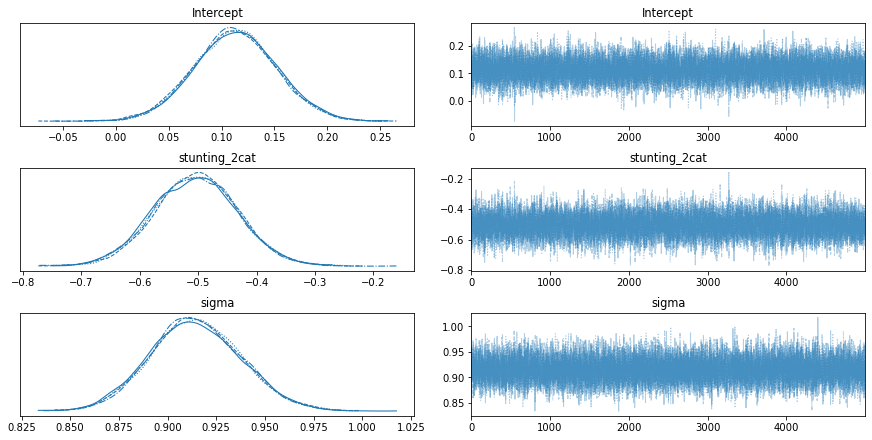

In [34]:
az.plot_trace(linear_trace)

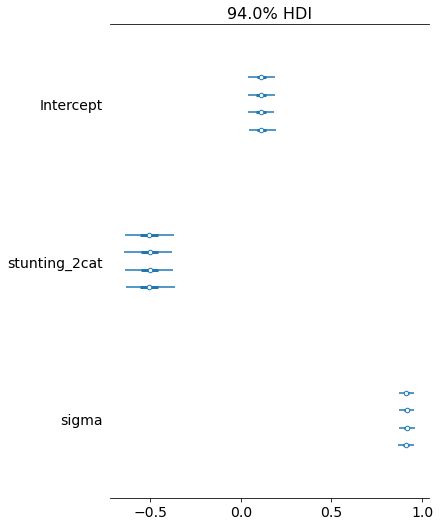

In [35]:
az.plot_forest(linear_trace);